<a href="https://colab.research.google.com/github/AravindDisha/CAA-Twitter-Analysis/blob/main/StanceAllModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#mount on other drive account for more space

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

import string
import re
import numpy as np
from nltk.corpus import words
from nltk.tokenize import word_tokenize
import pandas as pd
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.model_selection import cross_validate as cross_validation, ShuffleSplit, cross_val_score
import nltk
from nltk.stem.porter import PorterStemmer
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# filenames = ["/content/drive/My Drive/stance_data/models/Support_Vector_Machine_1.pkl","/content/drive/My Drive/stance_data/models/Random_Forest_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Gradient_Boosting_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Logistic_Regression_1.pkl","/content/drive/My Drive/stance_data/models/Neural_Network_1.pkl","/content/drive/My Drive/stance_data/models/Gaussian_NB_1.pkl","/content/drive/My Drive/stance_data/models/K_Neighbors_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Decision_Tree_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Support_Vector_Machine_2.pkl","/content/drive/My Drive/stance_data/models/Random_Forest_Classifier_2.pkl","/content/drive/My Drive/stance_data/models/Gradient_Boosting_Classifier_2.pkl","/content/drive/My Drive/stance_data/models/Logistic_Regression_2.pkl","/content/drive/My Drive/stance_data/models/Neural_Network_2.pkl","/content/drive/My Drive/stance_data/models/Gaussian_NB_2.pkl","/content/drive/My Drive/stance_data/models/K_Neighbors_Classifier_2.pkl","/content/drive/My Drive/stance_data/models/Decision_Tree_Classifier_2.pkl","/content/drive/My Drive/stance_data/models/lstm1_3.pkl","/content/drive/My Drive/stance_data/models/lstm2_3.pkl","/content/drive/My Drive/stance_data/models/lstm1_4.pkl","/content/drive/My Drive/stance_data/models/lstm2_4.pkl"]
# filenames

# Implementation of stance detection problem using ***Glove*** vectorization and baseline model - ***Demon datatset***

In [ ]:
models1 = {}

In [ ]:
def labelStance(labelDict, data):
	for key, val in labelDict.items():
		data.loc[data["Stance"] == val, "Stance"] = int(key)
	return data

def readGlobalVecData(glove_word_vec_file):
	file = open(glove_word_vec_file, encoding="utf8")
	rawData = file.readlines()
	glove_word_vec_dict = {}
	for line in rawData:
		line = line.strip().split()
		tag = line[0]
		vec = line[1:]
		glove_word_vec_dict[tag] = np.array(vec, dtype=float)
	return glove_word_vec_dict

def getWordVector(word, glove_word_vec_dict):
	if word in glove_word_vec_dict:
		return glove_word_vec_dict[word]
	return np.zeros_like(glove_word_vec_dict["dummy"])

def sumVectors(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = np.zeros_like(glove_word_vec_dict["dummy"])
	for word in finalList:
		vect = getWordVector(word,glove_word_vec_dict)
		if vect.sum() != 0:
			vector += vect
			numNonZero += 1
	if numNonZero:
		vector = vector/numNonZero
	return vector

def sumVectorsCNN(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = []
	for word in finalList:
		vector.append(getWordVector(word,glove_word_vec_dict))
	return vector

def simplify(word):
	dump = ''
	temp = []
	listOfWords = list(filter(None,re.split("([A-Z][^A-Z]*)",word)))
	if len(listOfWords) == len(word):
		return word.lower()
	for i in range(len(listOfWords)):
		listOfWords[i] = listOfWords[i].lower()
		if len(listOfWords[i]) == 1:
			dump = dump + listOfWords[i]
			if dump in words.words() and len(dump) > 2:
				temp.append(dump)
				dump = ''
		else:
			temp.append(listOfWords[i])
	return temp

def glove(glove_word_vec_dict, trainTweets):
    def createTokens(data,glove_word_vec_dict):
        listOfTweets = []
        listOfStances = []
        tweetVector = []
        for ind, row in data.iterrows():
            # Create a sentence using target and the tweet. Word vector will be formed from this.
            example_sentence = 'Demonitization' +' ' + str(row["text"])
            # Remove punctuation
            final_sentence = example_sentence.translate(string.punctuation)
            wordList = word_tokenize(final_sentence)
            finalList = []
            s = ' '.join([i for i in wordList if i.isalpha()])
            # create tokens from the string and stem them
            wordList = word_tokenize(s)
            wordList = [w.lower() for w in wordList]
            stop_words = set(stopwords.words('english'))
            wordList = [w for w in wordList if not w in stop_words]
            for word in wordList:
                #to break any combined word into its components for eg, hashtags
                finalList += simplify(word)
            final_sentence = ' '.join(finalList)
            listOfTweets.append(final_sentence)
            listOfStances.append(row["Stance"])
            tweetVector.append(sumVectors(finalList,glove_word_vec_dict))
        return listOfTweets, listOfStances, tweetVector
    # Remove punctuation from and tokenize the tweets
    listOfTweets, listOfStances, trainTweetVector = createTokens(trainTweets, glove_word_vec_dict)
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(trainTweetVector,listOfStances, test_size = 0.1, random_state = 42)

    Xtrain = np.asarray(X_train)
    Ytrain = np.asarray(Y_train)
    Xtest = np.asarray(X_test)
    Ytest = np.asarray(Y_test)
    return Xtrain, Ytrain, Xtest, Ytest


Loading Glove data in progress...

Loading Glove data is done...
Shape of label tensor: (2817, 3)

The Machine Learning Model Used For Classification : Support Vector Machine
Total Test Accuracy is 68.79%

The Machine Learning Model Used For Classification : Random Forest Classifier
Total Test Accuracy is 77.3%

The Machine Learning Model Used For Classification : Gradient Boosting Classifier
Total Test Accuracy is 78.01%

The Machine Learning Model Used For Classification : Logistic Regression
Total Test Accuracy is 65.96%

The Machine Learning Model Used For Classification : Neural Network
Total Test Accuracy is 56.74%

The Machine Learning Model Used For Classification : Gaussian NB
Total Test Accuracy is 50.71%

The Machine Learning Model Used For Classification : K Neighbors Classifier
Total Test Accuracy is 50.71%

The Machine Learning Model Used For Classification : Decision Tree Classifier
Total Test Accuracy is 71.63%


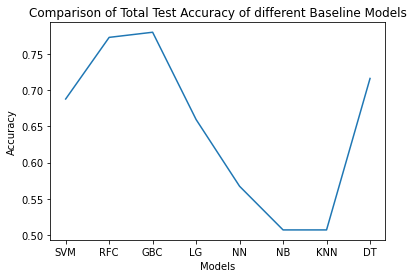

In [ ]:
gloveFile = "/content/drive/My Drive/stance_data/glove/glove.twitter.27B.200d.txt"

print("\nLoading Glove data in progress...")
glove_word_vec_dict = readGlobalVecData(gloveFile)
print("\nLoading Glove data is done...")

classifiers = ['Support Vector Machine', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'Logistic Regression', 'Neural Network', 'Gaussian NB', 'K Neighbors Classifier', 'Decision Tree Classifier']

training = "/content/drive/My Drive/stance_data/demon/csv_files/demoapril.csv"

Tweets = pd.read_csv(training,encoding='utf-8')
Tweets = Tweets.fillna(5)    

#For converting all the stances into numerical values in both training and test data
labelDict = {0:"A", 1:"F", 2:"N"}
Tweets = labelStance(labelDict, Tweets)
print('Shape of label tensor:', Tweets.shape)

totalAcc = []
Xtrain, Ytrain, Xtest, Ytest = glove(glove_word_vec_dict,Tweets)
for classifier in classifiers:
    print("\nThe Machine Learning Model Used For Classification : " + classifier)
    temp = []

    if classifier == 'Support Vector Machine':
      clf = SVC(kernel="rbf").fit(Xtrain, Ytrain)
      models1['Support Vector Machine'] = clf

    elif classifier == 'Random Forest Classifier':
      clf = RandomForestClassifier(n_estimators=90).fit(Xtrain, Ytrain)
      models1[classifier] = clf

    elif classifier == 'Gradient Boosting Classifier':
      clf = GradientBoostingClassifier().fit(Xtrain, Ytrain)
      models1[classifier] = clf

    elif classifier == 'Logistic Regression':
      clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Xtrain, Ytrain)
      models1[classifier] = clf

    elif classifier == 'Neural Network':
      clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(Xtrain, Ytrain)
      models1[classifier] = clf

    elif classifier == 'Gaussian NB':
      clf = GaussianNB().fit(Xtrain, Ytrain)
      models1[classifier] = clf

    elif classifier == 'K Neighbors Classifier':
      clf = GaussianNB().fit(Xtrain, Ytrain)
      models1[classifier] = clf

    elif classifier == 'Decision Tree Classifier':
      clf = tree.DecisionTreeClassifier().fit(Xtrain, Ytrain)
      models1[classifier] = clf

    acc = clf.score(Xtest, Ytest)
    
    print("Total Test Accuracy is "+ str(round(acc*100,2)) +"%")
    totalAcc.append(acc)

import matplotlib.pyplot as plt

x  = ['SVM', 'RFC', 'GBC', 'LG', 'NN', 'NB', 'KNN', 'DT']
y  = totalAcc

plt.plot(x, y)
plt.plot()

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Total Test Accuracy of different Baseline Models")
plt.show()

# Implementation of stance detection problem using ***Glove*** vectorization and baseline model - ***SemEval dataset***



In [ ]:
models2 = {}

Shape of label tensor: (2814, 4)

The Machine Learning Model Used For Classification : Support Vector Machine
Total Test Accuracy is 65.81%

The Machine Learning Model Used For Classification : Random Forest Classifier
Total Test Accuracy is 64.93%

The Machine Learning Model Used For Classification : Gradient Boosting Classifier
Total Test Accuracy is 63.73%

The Machine Learning Model Used For Classification : Logistic Regression
Total Test Accuracy is 61.49%

The Machine Learning Model Used For Classification : Neural Network
Total Test Accuracy is 57.25%

The Machine Learning Model Used For Classification : Gaussian NB
Total Test Accuracy is 54.68%

The Machine Learning Model Used For Classification : K Neighbors Classifier
Total Test Accuracy is 54.68%

The Machine Learning Model Used For Classification : Decision Tree Classifier
Total Test Accuracy is 51.8%


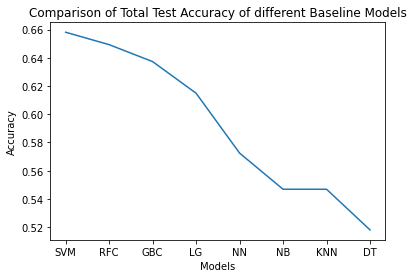

In [ ]:
def labelStance(labelDict, data):
	for key, val in labelDict.items():
		data.loc[data["Stance"] == val, "Stance"] = int(key)
	return data

def readGlobalVecData(glove_word_vec_file):
	file = open(glove_word_vec_file, encoding="utf8")
	rawData = file.readlines()
	glove_word_vec_dict = {}
	for line in rawData:
		line = line.strip().split()
		tag = line[0]
		vec = line[1:]
		glove_word_vec_dict[tag] = np.array(vec, dtype=float)
	return glove_word_vec_dict

# gloveFile = "/content/drive/My Drive/stance_data/glove/glove.twitter.27B.200d.txt"

# print("\nLoading Glove data in progress...")
# glove_word_vec_dict = readGlobalVecData(gloveFile)
# print("\nLoading Glove data is done...")

classifiers = ['Support Vector Machine', 'Random Forest Classifier', 'Gradient Boosting Classifier', 'Logistic Regression', 'Neural Network', 'Gaussian NB', 'K Neighbors Classifier', 'Decision Tree Classifier']

training = "/content/drive/My Drive/stance_data/semval/training.txt"
test = "/content/drive/My Drive/stance_data/semval/test-gold.txt"

trainTweets = pd.read_csv(training, sep='\t',header=0,encoding='utf-8')
testTweets = pd.read_csv(test, sep='\t',header=0,encoding='utf-8')

#For converting all the stances into numerical values in both training and test data
labelDict = {0:"AGAINST", 1:"FAVOR", 2:"NONE"}
trainTweets = labelStance(labelDict, trainTweets)
testTweets = labelStance(labelDict, testTweets)
print('Shape of label tensor:', trainTweets.shape)

def getWordVector(word, glove_word_vec_dict):
	if word in glove_word_vec_dict:
		return glove_word_vec_dict[word]
	return np.zeros_like(glove_word_vec_dict["dummy"])

def sumVectors(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = np.zeros_like(glove_word_vec_dict["dummy"])
	for word in finalList:
		vect = getWordVector(word,glove_word_vec_dict)
		if vect.sum() != 0:
			vector += vect
			numNonZero += 1
	if numNonZero:
		vector = vector/numNonZero
	return vector

def sumVectorsCNN(finalList, glove_word_vec_dict):
	numNonZero = 0
	vector = []
	for word in finalList:
		vector.append(getWordVector(word,glove_word_vec_dict))
	return vector

def simplify(word):
	dump = ''
	temp = []
	listOfWords = list(filter(None,re.split("([A-Z][^A-Z]*)",word)))
	if len(listOfWords) == len(word):
		return word.lower()
	for i in range(len(listOfWords)):
		listOfWords[i] = listOfWords[i].lower()
		if len(listOfWords[i]) == 1:
			dump = dump + listOfWords[i]
			if dump in words.words() and len(dump) > 2:
				temp.append(dump)
				dump = ''
		else:
			temp.append(listOfWords[i])
	return temp

def glove(glove_word_vec_dict, trainTweets, testTweets):
    def createTokens(data,glove_word_vec_dict):
        listOfTweets = []
        listOfStances = []
        tweetVector = []
        for ind, row in data.iterrows():
            # Create a sentence using target and the tweet. Word vector will be formed from this.
            example_sentence = str(row["Target"]) +' ' + str(row["Tweet"])
            # Remove punctuation
            final_sentence = example_sentence.translate(string.punctuation)
            wordList = word_tokenize(final_sentence)
            finalList = []
            s = ' '.join([i for i in wordList if i.isalpha()])
            # create tokens from the string and stem them
            wordList = word_tokenize(s)
            wordList = [w.lower() for w in wordList]
            stop_words = set(stopwords.words('english'))
            wordList = [w for w in wordList if not w in stop_words]
            for word in wordList:
                #to break any combined word into its components for eg, hashtags
                finalList += simplify(word)
            final_sentence = ' '.join(finalList)
            listOfTweets.append(final_sentence)
            listOfStances.append(row["Stance"])
            tweetVector.append(sumVectors(finalList,glove_word_vec_dict))
        return listOfTweets, listOfStances, tweetVector
    # Remove punctuation from and tokenize the training tweets
    listOfTweets, listOfStances, trainTweetVector = createTokens(trainTweets, glove_word_vec_dict)
    # Remove punctuation from and tokenize the test tweets
    listOfTestTweets, listOfTestStances, testTweetVector = createTokens(testTweets, glove_word_vec_dict)
    Xtrain = np.asarray(trainTweetVector)
    Ytrain = np.asarray(listOfStances)
    Xtest = np.asarray(testTweetVector)
    Ytest = np.asarray(listOfTestStances)
    return Xtrain, Ytrain, Xtest, Ytest

totalAcc = []
for classifier in classifiers:
    print("\nThe Machine Learning Model Used For Classification : " + classifier)
    temp = []
    
    Xtrain, Ytrain, Xtest, Ytest = glove(glove_word_vec_dict,trainTweets,testTweets)

    if classifier == 'Support Vector Machine':
      clf = SVC(kernel="rbf").fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'Random Forest Classifier':
      clf = RandomForestClassifier(n_estimators=90).fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'Gradient Boosting Classifier':
      clf = GradientBoostingClassifier().fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'Logistic Regression':
      clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'Neural Network':
      clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'Gaussian NB':
      clf = GaussianNB().fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'K Neighbors Classifier':
      clf = GaussianNB().fit(Xtrain, Ytrain)
      models2[classifier] = clf

    elif classifier == 'Decision Tree Classifier':
      clf = tree.DecisionTreeClassifier().fit(Xtrain, Ytrain)
      models2[classifier] = clf

    acc = clf.score(Xtest, Ytest)
    
    print("Total Test Accuracy is "+ str(round(acc*100,2)) +"%")
    totalAcc.append(acc)

import matplotlib.pyplot as plt

x  = ['SVM', 'RFC', 'GBC', 'LG', 'NN', 'NB', 'KNN', 'DT']
y  = totalAcc

plt.plot(x, y)
plt.plot()

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Total Test Accuracy of different Baseline Models")
plt.show()

# Stance Detection using ***Demonitisation*** Twitter DataSet and ***LSTM*** Model

In [ ]:
models3 = {}

In [ ]:
file = "/content/drive/My Drive/stance_data/demon/csv_files/demoapril.csv"

df = pd.read_csv(file,encoding='utf-8')
df.info()

## Tweet Preprocessing

import re
import nltk
from nltk.corpus import stopwords

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text)
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['text'] = df.text + ' ' + 'Demonitization'
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')

from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df['Stance']).values

print('Shape of label tensor:', Y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

## LSTM Model - 1

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

print(model.summary())

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
models3['lstm1'] = model

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

import matplotlib.pyplot as plt

# plt.title('Loss')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show();

# plt.title('Accuracy')
# plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_acc'], label='test')
# plt.legend()
# plt.show();

## CNN + LSTM Model - 2

from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM

y_dim=3
num_filters=200
filter_sizes=[3,4,5] 
pool_padding='valid' 
dropout=0.5

embed_input = Input(shape=(X.shape[1],))
x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(embed_input)
pooled_outputs = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
    conv = MaxPooling1D(pool_size=EMBEDDING_DIM-filter_sizes[i]+1)(conv)           
    pooled_outputs.append(conv)
merge = concatenate(pooled_outputs)
    
x = Dense(30, activation='relu')(merge)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = Dense(30, activation='relu')(x)
x = Dropout(dropout)(x)
x = Flatten()(x)
x = Dense(y_dim, activation='sigmoid')(x)

model = Model(inputs=embed_input,outputs=x)

#   model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
models3['lstm2'] = model 

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

import matplotlib.pyplot as plt

# plt.title('Loss')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show();

# plt.title('Accuracy')
# plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_acc'], label='test')
# plt.legend()
# plt.show();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2817 entries, 0 to 2816
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2817 non-null   object
 1   text    2814 non-null   object
 2   Stance  2811 non-null   object
dtypes: object(3)
memory usage: 66.1+ KB


Using TensorFlow backend.


Found 6540 unique tokens.
Shape of data tensor: (2817, 100)
Shape of label tensor: (2817, 3)
(2535, 100) (2535, 3)
(282, 100) (282, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 5,080,703
Trainable params: 5,080,703
Non-trainable params: 0
_________________________________________________________________
None
Train on 2281 samples, validate on 254 samples
Epoch 1/5
2281/2281 [==============================] - 

# Stance Detection using ***SemEval2016*** DataSet and ***LSTM*** Model


In [ ]:
models4 = {}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814 entries, 0 to 2813
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2814 non-null   int64 
 1   Target  2814 non-null   object
 2   Tweet   2814 non-null   object
 3   Stance  2814 non-null   object
dtypes: int64(1), object(3)
memory usage: 88.1+ KB
Found 8937 unique tokens.
Shape of data tensor: (2814, 100)
Shape of label tensor: (2814, 3)
(2814, 100) (2814, 3)
(1249, 100) (1249, 3)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
______

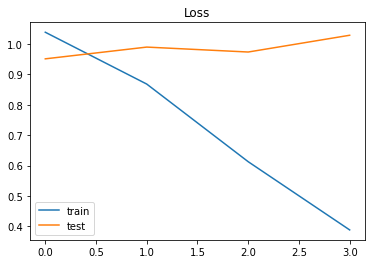

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 100)     5000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 98, 200)      60200       embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 97, 200)      80200       embedding_5[0][0]                
____________________________________________________________________________________________

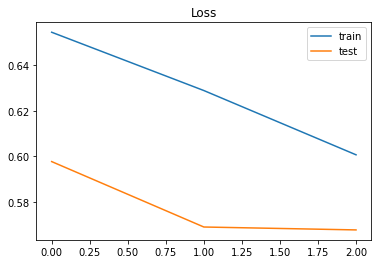

In [ ]:
import pandas as pd
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")

training = "/content/drive/My Drive/stance_data/semval/training.txt"
test = "/content/drive/My Drive/stance_data/semval/test-gold.txt"

df = pd.read_csv(training, sep='\t',header=0,encoding='utf-8')
test = pd.read_csv(test, sep='\t',header=0,encoding='utf-8')
df.info()

## Tweet Preprocessing

import re
import nltk
from nltk.corpus import stopwords

df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['Tweet'] = df.Tweet + ' ' + df.Target
df['Tweet'] = df['Tweet'].apply(clean_text)
df['Tweet'] = df['Tweet'].str.replace('\d+', '')

test['Tweet'] = test.Tweet + ' ' + test.Target
test['Tweet'] = test['Tweet'].apply(clean_text)
test['Tweet'] = test['Tweet'].str.replace('\d+', '')

from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

max_len = 0
for t in X:
    if max_len < len(t):
        max_len = len(t)

X1 = tokenizer.texts_to_sequences(test['Tweet'].values)
X1 = pad_sequences(X1, maxlen=max_len)

print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(df['Stance']).values

Y1 = pd.get_dummies(test['Stance']).values

print('Shape of label tensor:', Y.shape)

from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.0, random_state = 42)
# X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1,Y1, test_size = 1.0, random_state = 42)
X_train = X
X_test=X1
Y_train=Y
Y_test=Y1
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

## LSTM Model - 1

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

print(model.summary())

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
models4['lstm1'] = model

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

# plt.title('Accuracy')
# plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_acc'], label='test')
# plt.legend()
# plt.show();

## CNN + LSTM Model - 2

from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM

y_dim=3
num_filters=200
filter_sizes=[3,4,5] 
pool_padding='valid' 
dropout=0.5

embed_input = Input(shape=(X.shape[1],))
x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(embed_input)
pooled_outputs = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
    conv = MaxPooling1D(pool_size=EMBEDDING_DIM-filter_sizes[i]+1)(conv)           
    pooled_outputs.append(conv)
merge = concatenate(pooled_outputs)
    
x = Dense(30, activation='relu')(merge)
x = Dropout(dropout)(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = Dense(30, activation='relu')(x)
x = Dropout(dropout)(x)
x = Flatten()(x)
x = Dense(y_dim, activation='sigmoid')(x)

model = Model(inputs=embed_input,outputs=x)

#   model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['acc'])
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

print(model.summary())

epochs = 3
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
models4['lstm2'] = model

accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

# plt.title('Accuracy')
# plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_acc'], label='test')
# plt.legend()
# plt.show();

In [ ]:
import pickle
i = 0
for mods in [models1,models2,models3,models4]:
  i+=1
  # print(mods)
  # Save to file in the current working directory
  for mod in mods:
    # print(type(mods[mod]))
    mod_name = '_'.join(mod.split(' ')+[str(i)])
    pkl_filename = "/content/drive/My Drive/stance_data/models/"+mod_name+".pkl"
    print('"'+pkl_filename+'"',end=',')
    with open(pkl_filename, 'wb') as file:
        pickle.dump(mods[mod], file)

"/content/drive/My Drive/stance_data/models/Support_Vector_Machine_1.pkl","/content/drive/My Drive/stance_data/models/Random_Forest_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Gradient_Boosting_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Logistic_Regression_1.pkl","/content/drive/My Drive/stance_data/models/Neural_Network_1.pkl","/content/drive/My Drive/stance_data/models/Gaussian_NB_1.pkl","/content/drive/My Drive/stance_data/models/K_Neighbors_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Decision_Tree_Classifier_1.pkl","/content/drive/My Drive/stance_data/models/Support_Vector_Machine_2.pkl","/content/drive/My Drive/stance_data/models/Random_Forest_Classifier_2.pkl","/content/drive/My Drive/stance_data/models/Gradient_Boosting_Classifier_2.pkl","/content/drive/My Drive/stance_data/models/Logistic_Regression_2.pkl","/content/drive/My Drive/stance_data/models/Neural_Network_2.pkl","/content/drive/My Drive/stance_data/models/Gaussian_